In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize
# from simpeg import dask
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation, MetaSimulation


Solver = get_default_solver()


directory = "./synthetic-data-10m"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

files.remove("rx_locs.txt")
rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")
# rx_locs[:, 1] =

files.remove("rx_times.txt")
rx_times = np.loadtxt(f"{directory}/rx_times.txt")

inv_directory = "/t40array/lheagy/2025-heagy-et-al-tle/synthetic-invs-3d" 



In [2]:
base_cell_width = 10
domain_extent = 8000

n_base_cells = 2 ** int(
    np.ceil(np.log(domain_extent / base_cell_width) / np.log(2.0))
)  # needs to be powers of 2 for the tree mesh

h = [(base_cell_width, n_base_cells)]
mesh = discretize.TreeMesh([h, h, h], origin="CCC", diagonal_balance=True)

# refine near transmitters and receivers
mesh.refine_points(
    rx_locs, level=-1, padding_cells_by_level=[4, 8, 8, 2], 
    finalize=False, diagonal_balance=True
)

# Refine core region of the mesh 

bounding_points = np.array([
    [-520, rx_locs[:, 1].min()-10, -200 - base_cell_width * 4], 
    [520, rx_locs[:, 1].max()+10, rx_locs[:, 2].max()+10],
])
mesh.refine_bounding_box(
    bounding_points, level=-1, 
    diagonal_balance=True, finalize=False, padding_cells_by_level=[4, 8, 8, 2]
)

mesh.finalize()

In [3]:
mesh

OcTreeMesh,0.02% filled
Level,Number of cells
3,448
4,392
5,540
6,1600
7,7024
8,47784
9,62352
10,55680
Total,175820


In [4]:
-200 - base_cell_width * 4

-240

(-1200.0, 800.0)

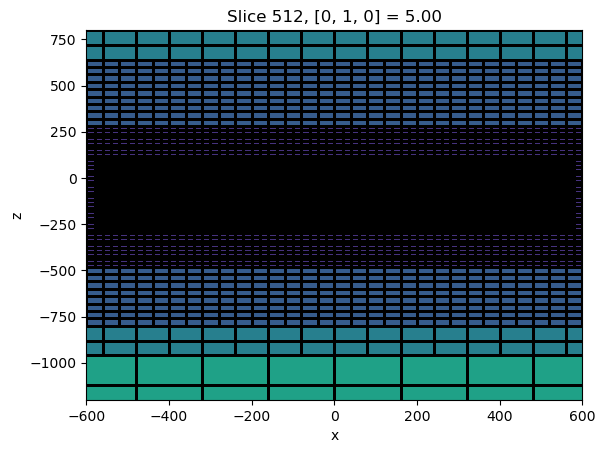

In [5]:
fig, ax = plt.subplots(1, 1)

mesh.plot_slice(
    np.log10(mesh.cell_volumes), ax=ax, grid=True,
    normal="Y"
)

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(-1200, 800)

In [6]:
dobs_dict = {}

for f in files:
    key = f.split(".")[0]
    dobs_dict[key] = np.loadtxt(f"{directory}/{f}")
    
data_dict = {}
for key, value in dobs_dict.items():
    source_list = []
    for i in range(rx_locs.shape[0]):
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)

    full_survey = tdem.Survey(source_list)

    data_dict[key] = Data(survey=full_survey, dobs=value)



In [7]:
n_times_invert = 20
data_dict_invert = {}
    
for key, value in dobs_dict.items():

    source_list = []

    for i in range(rx_locs.shape[0]):
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)

    survey = tdem.Survey(source_list)

    data_dict_invert[key] = Data(
        survey=survey,
        dobs=(value.reshape(rx_locs.shape[0], len(rx_times))[:, :n_times_invert]).flatten(),
        relative_error=0.1,
        noise_floor=1e-11
    )

In [8]:
downsample_inds = [0, 1, 2]

In [9]:
# downsample = 52
downsampled_data_dict = {}

for key, val in data_dict_invert.items():
    source_list_downsampled = [val.survey.source_list[ii] for ii in downsample_inds]
    survey_downsampled = tdem.Survey(source_list_downsampled)
    downsampled_data_dict[key] = Data(
        survey=survey_downsampled,
        dobs=np.hstack(
            [val[src, src.receiver_list[0]] for src in source_list_downsampled]
        ),
        noise_floor=1e-11,
        relative_error=0.1
   )

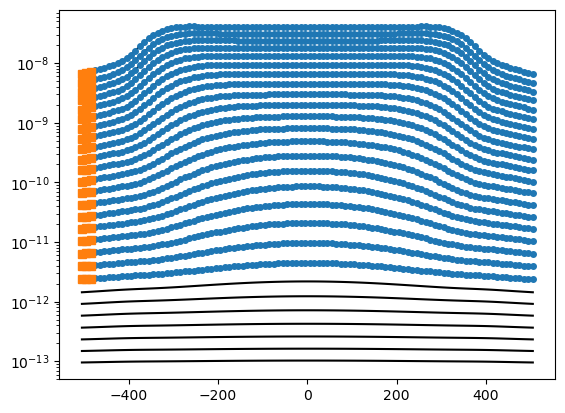

In [10]:
fig, ax = plt.subplots(1, 1)

ax.semilogy(rx_locs[:,0], -data_dict["target_0"].dobs.reshape(len(source_list), 27), color="k");
ax.semilogy(rx_locs[:,0], -data_dict_invert["target_0"].dobs.reshape(len(source_list), 20), "C0o", ms=4);
ax.semilogy(rx_locs[downsample_inds, 0], -downsampled_data_dict["target_0"].dobs.reshape(len(source_list_downsampled), 20), "C1s");


In [11]:
data_invert = downsampled_data_dict["target_0"]

In [12]:
rho_back = 500
refine_depth = 120
active_cells_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))
survey = data_invert.survey

mesh_list = []

for src in survey.source_list:
    mesh_local = discretize.TreeMesh(mesh.h, origin=mesh.origin, diagonal_balance=True)
    # refine_points = discretize.utils.ndgrid(
    #     np.r_[src.location[0]],
    #     np.r_[src.location[1]],
    #     np.linspace(-refine_depth, src.location[2], 40)
    # )
    # mesh_local.refine_points(
    #     refine_points,
    #     level=-1,
    #     padding_cells_by_level=[2, 4, 6, 2],
    #     finalize=True,
    #     diagonal_balance=True
    # )

    bounding_points = np.array([
        [src.location[0]-5, src.location[1]-5, -refine_depth], 
        [src.location[0]+5, src.location[1]+5, src.location[2]],
    ])
    mesh_local.refine_bounding_box(
        bounding_points, level=-1, 
        diagonal_balance=True, finalize=False, padding_cells_by_level=[2, 8, 8] #[1, 4, 6, 2]
    )
    
    mesh_local.finalize()
    
    # mesh_local.x0=[x1, x2, x3]
    # print(x1, x2, x3)
    
    mesh_list.append(mesh_local)

(<matplotlib.collections.PolyCollection at 0x7f5bfec69bd0>,)

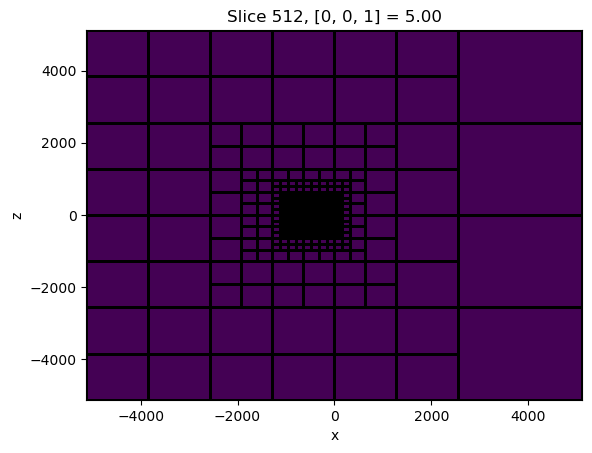

In [13]:
local_mesh = mesh_list[0]
local_mesh.plot_slice(np.ones(local_mesh.n_cells), grid=True)

In [14]:
len(mesh_list)

3

In [15]:
time_steps = [
    (1e-6, 30),
    (3e-6, 30),
    (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]


mappings = []
sims = []

for ii, local_mesh in enumerate(mesh_list):

    tile_map = maps.TileMap(mesh, active_cells_map.active_cells, local_mesh)
    mappings.append(tile_map)

    local_actmap = maps.InjectActiveCells(
        local_mesh,
        active_cells=tile_map.local_active,
        value_inactive=np.log(1e-8)
    )

    local_survey = tdem.Survey([survey.source_list[ii]])
    sims.append(tdem.simulation.Simulation3DElectricField(
            mesh=local_mesh,
            survey=local_survey,
            time_steps=time_steps,
            solver=Solver,
            sigmaMap=maps.ExpMap() * local_actmap
        )
    )


# sim = MetaSimulation(sims, mappings)
sim = MultiprocessingMetaSimulation(sims, mappings)


/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/simpeg/meta/multiprocessing.py:229: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  super().__init__(simulations, mappings)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/simpeg/meta/multiprocessing.py:248: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  sim_chunk = MetaSimulation(
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broa

In [16]:

dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_invert)
reg = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells_map.active_cells,
    # alpha_s=1e-6,
    # alpha_x=alpha_x,
    # reference_model=np.log(1./rho_back),
    # norms=norms
)

opt = optimization.InexactGaussNewton(maxIter=15, maxIterCG=30, tolCG=1e-3)
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)

cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)

# Update the preconditionner
# update_Jacobi = directives.UpdatePreconditioner()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputDictEveryIteration(
    saveOnDisk=True, name=f"inv-dict-{key}"
)


target_misfit = directives.TargetMisfit(chifact=0.5)

# The directives are defined as a list.
directives_list = [
    # sensitivity_weights,
    # update_jacobi,
    starting_beta,
    cool_beta,
    save_iteration,
    target_misfit,
]

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)
m0 = np.log(1/rho_back) * np.ones(np.sum(active_cells_map.active_cells))

In [17]:
if __name__ == "__main__": 
    mrec = inv.run(m0)


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
simpeg.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-inv-dict-target_45-2025-06-14-11-28.npz'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-

In [18]:
np.min(np.exp(inv.invProb.model))

np.float64(7.193581317913229e-06)

In [19]:
np.max(np.exp(inv.invProb.model))

np.float64(0.06763807243580522)